In [1]:
import pickle
import matplotlib.pyplot as plt
import math
import numpy

import plotTools as pt

plt.rcParams.update({"text.usetex": True,"font.family": "serif"})
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']

In [2]:
cosmoParamsPretty = {'omega_c_h2' : '$\Omega_ch^2$', \
                         'omega_b_h2' :    '$\Omega_bh^2$', \
                         'N_eff':   '$N_{eff}$', \
                         'A_s' :  '$A_s$', \
                         'n_s' : '$n_s$', \
                         'tau' :  r'$\tau$', \
                         'theta_s': r'$\theta_s$', \
                         'Mnu' : r'$M_\nu$', \
                         'Yhe' : r'$Y_{He}$', \
                        'f_cdi': '$f_\mathrm{cdi}$', \
                        'n_cdi': '$n_{cdi}$', \
                        'c_ad_cdi': '$c_{ad\;\;cdi}$', \
                        'r': '$r$'}

In [3]:
jobNameCDIcorr = 'fisher_cdi_correlated'

jobNameCDIuncorr = 'fisher_cdi_uncorrelatedblue'

In [4]:
pythonFlag = 3
nExps = 20
sTypes = ["lensed","delensed","unlensed"]
gTypes = ["Gaussian","NonGaussian"]
noiseLevelsHi = numpy.arange(0.5, 10.5, 0.5)
fsky=0.5

fishersCDIcorr, cosmoParamsCDIcorr = pt.loadGaussianNG(jobName = jobNameCDIcorr, pythonFlag = pythonFlag, \
                                  returnCosmoParams = True)

fishersCDIuncorr, cosmoParamsCDIuncorr = pt.loadGaussianNG(jobName = jobNameCDIuncorr, pythonFlag = pythonFlag, \
                               returnCosmoParams = True)

paramsToFix = ['N_eff','mnu']
#paramsToFix = ['']

In [5]:
# fisher + fix + fsky + tau -> invert

for i in range(0,20):
    for gt, gaussianType in enumerate(gTypes):
        for st, spectrumType in enumerate(sTypes):
            
            fisher = fishersCDIcorr[gaussianType][spectrumType][i]
            fishersCDIcorr[gaussianType][spectrumType][i], fixedParamsCDIcorr = pt.fixParameters(fisher = fisher,\
                                                                               cosmoParams = cosmoParamsCDIcorr,\
                                                                               paramsToFix = paramsToFix,\
                                                                               returnFixedParamList = True)
            
            fisher = fishersCDIuncorr[gaussianType][spectrumType][i]
            fishersCDIuncorr[gaussianType][spectrumType][i], fixedParamsCDIuncorr = pt.fixParameters(fisher = fisher,\
                                                                                 cosmoParams = cosmoParamsCDIuncorr,\
                                                                                 paramsToFix = paramsToFix,\
                                                                                 returnFixedParamList = True)

fishersSkyCDIcorr = pt.addfsky(fishersCDIcorr, fsky)
fishersSkyCDIuncorr = pt.addfsky(fishersCDIuncorr, fsky)

fishersTauCDIcorr = pt.addTau(fishersSkyCDIcorr, fixedParamsCDIcorr)
fishersTauCDIuncorr = pt.addTau(fishersSkyCDIuncorr, fixedParamsCDIuncorr)

sigmasCDIcorr = pt.invertFishers(fishersTauCDIcorr)
sigmasCDIuncorr = pt.invertFishers(fishersTauCDIuncorr)

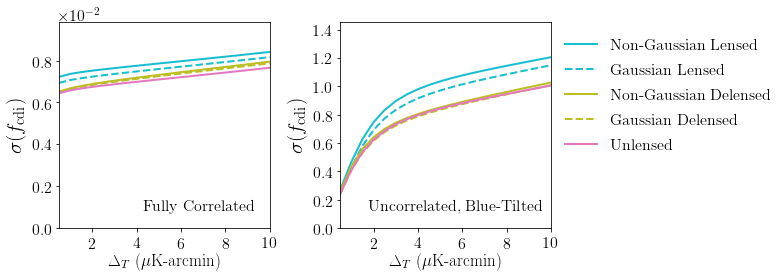

In [6]:
plt.figure('param constraints',  figsize = (11,4))
plt.clf()

toPlotng = numpy.zeros(nExps)
toPlotg = numpy.zeros(nExps)

paramsToPlot = ['f_cdi']

for cp in range(2):
    paramInd = fixedParamsCDIcorr.index('f_cdi')

    ax = plt.subplot(1, 2, cp + 1)
    ax.margins(0.0,0.05)
    
    for st, spectrumType in enumerate(sTypes):
        for gt, gaussianType in enumerate(['NonGaussian','Gaussian']):
            linestyles = ['--', '-', '-.']
            widths = [2, 2]
            colors = ['C9', 'C8', 'C6']

            for ei in range(0,nExps):
                if cp == 0:
                    toPlotng[ei] = math.sqrt(numpy.diag(sigmasCDIcorr['NonGaussian'][spectrumType][ei])[paramInd])
                    toPlotg[ei] = math.sqrt(numpy.diag(sigmasCDIcorr['Gaussian'][spectrumType][ei])[paramInd])
                    legendLabel = spectrumType
                if cp == 1:
                    toPlotng[ei] = math.sqrt(numpy.diag(sigmasCDIuncorr['NonGaussian'][spectrumType][ei])[paramInd])
                    toPlotg[ei] = math.sqrt(numpy.diag(sigmasCDIuncorr['Gaussian'][spectrumType][ei])[paramInd])
                    legendLabel = spectrumType
        
            if gaussianType == 'NonGaussian':
                if spectrumType == 'unlensed':
                    plt.plot(noiseLevelsHi, toPlotng, color = colors[st], linestyle = linestyles[1], \
                                linewidth = widths[0], label = 'Unlensed')
                else:
                    if spectrumType == 'lensed':
                        legendLabel = 'Lensed'
                    elif spectrumType == 'delensed':
                        legendLabel = 'Delensed'
                    plt.plot(noiseLevelsHi, toPlotng, color = colors[st], linestyle = linestyles[1], \
                                linewidth = widths[0], label = 'Non-Gaussian '+legendLabel)
            if gaussianType == 'Gaussian':
                if spectrumType == 'delensed' or spectrumType == 'lensed':
                    if spectrumType == 'lensed':
                        legendLabel = 'Lensed'
                    elif spectrumType == 'delensed':
                        legendLabel = 'Delensed'
                    plt.plot(noiseLevelsHi, toPlotg, color = colors[st], linestyle = linestyles[0], \
                    linewidth = widths[0], label = 'Gaussian '+legendLabel)
            
        ymin, ymax = plt.ylim()
        plt.ylim(ymin=0.0, ymax = ymax*1.05)
    plt.ylabel('$\sigma($' + cosmoParamsPretty['f_cdi'] + '$)$', fontsize = 21)
    plt.xlabel('$\Delta_T$ ($\mu$K-arcmin)', fontsize = 17)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    if cp == 0:
        ax.text(0.40, 0.15, 'Fully Correlated', transform=ax.transAxes, fontsize=16, verticalalignment='top')
    elif cp == 1:
        ax.text(0.13, 0.15, 'Uncorrelated, Blue-Tilted', transform=ax.transAxes, fontsize=16, verticalalignment='top')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.offsetText.set_fontsize(16)
plt.legend(bbox_to_anchor = (1., 1.), loc = 2, frameon = False, fontsize=16)
plt.tight_layout()
plt.savefig('fig_cdm_iso.pdf')
plt.show()